## 2. Modul

Adatok előfeldolgozása - Data preprocessing

Feltáró adatelemzés - EDA (Exploratory Data Analysis)

### Versek osztályozása szerzők szerint

Bináris osztályozási feladat
- Ady Endre versek (osztálycímke): 1
- Más szerzők versei (osztálycímke): 0

In [1]:
%%capture
%pip install --upgrade pip
!pip3 install upgrade-pip
%pip install matplotlib
%pip install numpy
%pip install scikit-learn
%pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import logging
import inspect
import traceback
import sys

In [3]:
# print(f'Python: {sys.version}')
# print(f'pandas: {pd.__version__}')
# print(f'numpy: {np.__version__}')
# print(f'matplotlib: {mpl.__version__}')

In [4]:
pd.set_option('display.width', 1000)

Grafikon az osztályok kiegyensúlyozottságának szemléltetéséhez

In [5]:
def get_plot_classes_rate(df, class_label_column, class_label_list, title): 

    if len(class_label_list) != 2:
        print("Kettőnél kevesebb vagy több oszlopnevet adott meg!")
        return
    
    try:       

        class_label_counts = df[class_label_column].value_counts()
        total_length = len(df)
        rates = [class_label_counts[1] / total_length, class_label_counts[0] / total_length]
        colors = ['darkcyan', '#cd3838']
        plt.figure(figsize = (4, 4))
        
        bars = plt.bar(class_label_list, rates, color = colors)
        plt.xlabel('Osztályok')
        plt.ylabel('Arányszám')
        plt.title(title)
        
        plt.ylim(0, 1)
        
        for bar, rate in zip(bars, rates):
            plt.text(bar.get_x() + bar.get_width() / 2, rate - 0.05, f'{rate:.3f}', ha = 'center', va = 'center', color = 'black')

        legend_handles = [plt.Rectangle((0, 0), 1, 1, color = col) for col in colors]
        plt.legend(legend_handles, class_label_list)

        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt az osztály arányok kimutatásánál ({def_name}):', e)
        logging.info(f'Hiba történt az osztály arányok kimutatásánál ({def_name})')

Hiányos jellemzők kimutatása szerzőnként

In [6]:
def get_incomplete_poem_features(df, author, first_column, last_column):
    
    try:

        mask = (df['nan_count_label'] > 0) & (df['author'] == author)    
        original_indices = df[mask].index
        df_incomplete = df[mask].copy()
        df_incomplete['nan_list'] = [list() for _ in range(len(df_incomplete))] 
        
        for index, row in df_incomplete.iterrows():
            nan_columns = [col for col in row.index[first_column:last_column] if pd.isna(row[col])]
            df_incomplete.at[index, 'nan_list'] = nan_columns
            
        df_incomplete = df_incomplete[df_incomplete.columns[1:2].to_list() + df_incomplete.columns[-2:].to_list()]

        return df_incomplete, original_indices
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a hiányos adatok kimutatásakor ({def_name}):', e)
        logging.info(f'Hiba történt a hiányos adatok kimutatásakor ({def_name})')

Hiányos jellemzők gyakorisága

In [7]:
def get_frequency_incomplete_features(df, column_name, feature_names):

    try:

        frequency_incomplete_features = {}
        for feature_name in feature_names:
            count = df[column_name].apply(lambda x: feature_name in x).sum()
            if count > 0:
                frequency_incomplete_features[feature_name] = count
                
        return frequency_incomplete_features
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a hiányos versek kimutatásakor ({def_name}):', e)
        logging.info(f'Hiba történt a hiányos versek kimutatásakor ({def_name})')

### Lineáris (Pearson) és nemlineáris (Spearman) korreláció

Függvények:
- Korrelációs mátrixok
- Hőtérkép megjelenítése korrelációs mátrix alapján (opcionálisan használható)
- Segédfüggvény az interaktív hőtérképekhez
- Interaktív hőtérképek megjelenítése (korrelációs kapcsolat erősségének szabályozása csúszkával)

In [8]:
def correlation_matrix_pearson_spearman(df, pearson, spearman, first_column, last_column):

    try:

        df_num = df.iloc[:, first_column:last_column]
        # print(df_num)

        correlation_matrix_pearson = df_num.corr(method = 'pearson')    

        correlation_matrix_spearman = df_num.corr(method = 'spearman')
        
        if pearson == True:    
            print(correlation_matrix_pearson)
        if spearman == True:    
            print(correlation_matrix_spearman)

        return correlation_matrix_pearson, correlation_matrix_spearman
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a korrelációs mátrixok számításakor ({def_name}):', e)
        logging.info(f'Hiba történt a korrelációs mátrixok számításakor ({def_name})')

# def correlation_matrix_heatmap(df, title):

#     try:

#         plt.figure(figsize = (8, 7))
#         sns.heatmap(df, cmap = 'coolwarm', center = 0, vmin = -1, vmax = 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(title)
#         plt.show()

#     except Exception as e:

#         def_name = inspect.currentframe().f_code.co_name
#         print(f'Hiba történt a korrelációs mátrix megjelenítésekor ({def_name}):', e)
#         logging.info(f'Hiba történt a korrelációs mátrix megjelenítésekor ({def_name})')

def correlation_matrix_heatmap_differences(df1, df2, title1, title2, tick_labels):

    try:

        plt.figure(figsize = (10, 4))
        def correlation_matrix_heatmap_for_diff(subplot_index, df, title):
            plt.subplot(1, 2, subplot_index)
            sns.heatmap(df, cmap = 'coolwarm', vmin = -1, vmax = 1, xticklabels = tick_labels, yticklabels = tick_labels)
            plt.title(title)
        correlation_matrix_heatmap_for_diff(1, df1, title1)
        correlation_matrix_heatmap_for_diff(2, df2, title2)
        plt.subplots_adjust(wspace = 2.0)  # Grafikonok közötti távolság beállítása
        plt.tight_layout()
        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a korrelációs mátrixok összehasonlításakor ({def_name}):', e)
        logging.info(f'Hiba történt a korrelációs mátrixok összehasonlításakor ({def_name})')

def correlation_matrix_treshold(df_pearson, df_spearman, tick_labes):

    treshold_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05, description='Treshold:')
    treshold = treshold_slider.value
    output = widgets.Output()

    # Csúszka megjelenítése
    display(treshold_slider, output)

    # Az abszolút érték alapján korrelációs mátrixok szűrése
    def strong_correlations(change):
        
        output.clear_output()    
        with output:
            treshold = treshold_slider.value
            strong_correlation_pearson_mask = df_pearson.abs() > treshold
            strong_correlation_spearman_mask = df_spearman.abs() > treshold

            # Erős korrelációs értékek kiemelése
            correlation_matrix_pearson_filtered = df_pearson[strong_correlation_pearson_mask]
            correlation_matrix_spearman_filtered = df_spearman[strong_correlation_spearman_mask]

            correlation_matrix_heatmap_differences(correlation_matrix_pearson_filtered, correlation_matrix_spearman_filtered, 'Lineáris kapcsolatok', 'Nemlineáris kapcsolatok', tick_labes)

    treshold_slider.observe(strong_correlations, names = 'value')

    strong_correlations(None)

### Eloszlások vizualizációja

Függvények:
- Segédfüggvény legördülő menü létrehozásához
- Egyes jellemzők eloszlása (interaktív pontdiagram, hisztogram, dobozdiagram)
- Egyes jellemzők eloszlása osztályonként (interaktív dobozdiagramok)

In [9]:
def dropdown_features(df, features):

    try:

        feature_options = [col for col in df.columns if col not in features]

        return feature_options
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a legördülő menü elemeinek meghatározásakor ({def_name}):', e)
        logging.info(f'Hiba történt a legördülő menü elemeinek meghatározásakor ({def_name})')

def distributions(df, feature_options, initial_feature):

    try:

        # Eseménykezelő a jellemzők legördülő menü változásához
        def dropdown_eventhandler_plots(change):
            feature = change.new
            update_plots(feature)

        # Függvény a diagramok frissítéséhez a jellemző kiválasztása alapján
        def update_plots(feature):
            clear_output(wait = True)  # Az előző diagramok törlése
            plt.close()

            fig, axes = plt.subplots(1, 3, figsize = (15, 4))

            # Scatter plot
            sns.scatterplot(data = df, x = df.index, y = feature, ax = axes[0], color = 'darkcyan')
            axes[0].set_title('Scatter plot')
            axes[0].set_xlabel('Index')
            axes[0].set_ylabel(feature)

            # Hisztogram
            sns.histplot(data = df, x = feature, ax = axes[1], bins = 10, kde = True, color = 'darkcyan', linewidth = 0.5).lines[0].set_color('#cd3838')
            axes[1].set_title('Simított eloszlás')

            # Boxplot
            sns.boxplot(data = df, x = feature, ax = axes[2], showmeans = True, meanprops = {"markerfacecolor":"white", "markeredgecolor":"white"}, color = 'darkcyan')
            axes[2].set_title('Boxplot')
            axes[2].grid(True)

            plt.tight_layout()
            plt.show()

            # Legördülő menü újra megjelenítése
            display(dropdown)

        # Widget létrehozása a jellemzőknek
        dropdown = widgets.Dropdown(options = feature_options, description = 'Jellemzők:')

        # Eseménykezelő hozzáadása a jellemzők legördülő menüjéhez
        dropdown.observe(dropdown_eventhandler_plots, names = 'value')

        # Kezdő diagram létrehozása
        update_plots(initial_feature)

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt az adatok megoszlásának kimutatásakor ({def_name}):', e)
        logging.info(f'Hiba történt az adatok megoszlásának kimutatásakor ({def_name})')

def distributions_by_class(df, features, initial_feature):

    try:

        def update_boxplot(feature):
            clear_output(wait = True)  # Az előző diagram törlése
            plt.close()

            colors = {0: '#cd3838', 1: 'darkcyan'}
            sns.set_theme(style = 'whitegrid')
            boxplot = sns.boxplot(x = feature, data = df, hue = 'class_label', palette = colors, showmeans = True, meanprops = {"markerfacecolor":"white", "markeredgecolor":"white"})
            boxplot.axes.set_title("Adatok megoszlása osztályonként", fontsize = 16)
            boxplot.set_xlabel(feature, fontsize = 14)
            boxplot.set_ylabel("Osztályok", fontsize = 14)

            handles, _ = boxplot.get_legend_handles_labels()
            boxplot.legend(handles = handles, labels = ['Nem Ady', 'Ady'])

            plt.show()

            # Legördülő menü újra megjelenítése
            display(dropdown)

        # Widget létrehozása
        dropdown = widgets.Dropdown(options = features, description = 'Jellemzők:')

        # Eseménykezelő a legördülő menü változásához
        def dropdown_eventhandler_boxplot(change):
            feature = change.new
            update_boxplot(feature)

        # Eseménykezelő hozzáadása a legördülő menühöz
        dropdown.observe(dropdown_eventhandler_boxplot, names = 'value')

        # Kezdő dobozdiagram létrehozása

        update_boxplot(initial_feature)

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt az adatok osztályonkénti megoszlásakor ({def_name}):', e)
        logging.info(f'Hiba történt az adatok osztályonkénti megoszlásakor ({def_name})')

### Eloszlások vizualizációja

Két-két jellemző együttes eloszlása (interaktív relációs pontdiagram, kernelsűrűség)

In [10]:
def pairplot_distributions(df, features):

    try:

        # Függvény a diagramok frissítéséhez az érték alapján
        def update_plots(feature_x, feature_y):
            with output:
                output.clear_output(wait = True)  # Az előző diagramok törlése
                plt.close()

                fig, axes = plt.subplots(1, 2, figsize = (10, 4))
                colors = ['#cd3838', 'darkcyan']

                # Első subplot: scatterplot
                sns.scatterplot(data = df, x = feature_x, y = feature_y, hue = "class_label", ax = axes[0], palette = colors)

                # Második subplot: kdeplot (Kernel Density Estimate)
                sns.kdeplot(data = df, x = feature_x, y = feature_y, hue = "class_label", ax = axes[1], palette = colors)

                # Az ábrák címeinek beállítása
                axes[0].set_title('Relációs pontdiagram')
                axes[1].set_title('Kernel sűrűségbecslés')

                # További finomhangolások
                plt.tight_layout()
                plt.show()

        # Widget létrehozása
        dropdown_x = widgets.Dropdown(options = features, description = 'X tengely:')
        dropdown_y = widgets.Dropdown(options = features, description = 'Y tengely:')

        # Eseménykezelő a legördülő menük változásához
        def dropdown_eventhandler(change):
            feature_x = dropdown_x.value
            feature_y = dropdown_y.value
            
            # Hibakezelés az azonos változókra
            if feature_x == feature_y:
                with output:
                    print("Ugyanazt a változót választottad mindkét tengelyre. Kérlek válassz másikat.")
                return
            
            update_plots(feature_x, feature_y)

        # Eseménykezelők hozzáadása a legördülő menükhoz
        dropdown_x.observe(dropdown_eventhandler, names = 'value')
        dropdown_y.observe(dropdown_eventhandler, names = 'value')

        # Kezdő diagramok létrehozása
        initial_feature_x = "nWord_title"  # X tengely alapértelmezett értéke
        initial_feature_y = "nStanza"  # Y tengely alapértelmezett értéke

        output = widgets.Output()
        update_plots(initial_feature_x, initial_feature_y)

        # Az alapértelmezett érték beállítása a legördülő menük számára
        dropdown_x.value = initial_feature_x
        dropdown_y.value = initial_feature_y

        # Legördülő menük és output megjelenítése
        display(dropdown_x)
        display(dropdown_y)
        display(output)

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a külöböző oszlopok összefügéseinek kimutatásakor ({def_name}):', e)
        logging.info(f'Hiba történt a külöböző oszlopok összefügéseinek kimutatásakor ({def_name})')

### Relatív szórások jellemzőnként

Függvények:
- Segédfüggvény relatív szórás számításához
- Relatív szórások számítása
- Relatív szórások megjelenítése vonaldiagramon

In [11]:
def relative_std(series):    

    try:

        return series.std() / series.mean()
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a relatív szórás számításakor ({def_name}):', e)
        logging.info(f'Hiba történt a relatív szórás számításakor ({def_name})')

def relative_std_datas(df, sort_bool, first_column, last_column, last_record):

    try:

        # DataFrame létrehozása a relatív szórás kiszámítása után
        df_rel_stds = pd.DataFrame(df.iloc[:, first_column:last_column].apply(relative_std), columns = ["Relatív szórás"])

        # Oszlopnevek hozzáadása a DataFrame-hez
        df_rel_stds["Original_column_names"] = df_rel_stds.index

        rel_stds_df_sorted = df_rel_stds.sort_values(by = 'Relatív szórás', ascending = False)

        # Csak a "Relatív szórás" oszlop megőrzése az új DataFrame-ben
        rel_stds_df_sorted = rel_stds_df_sorted[["Relatív szórás"]]

        if sort_bool == True:
            print(rel_stds_df_sorted[:last_record])

        return df_rel_stds
    
    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a relaítv szórás számításakor a DataFrame adataira ({def_name}):', e)
        logging.info(f'Hiba történt a relaítv szórás számításakor a DataFrame adataira ({def_name})')

def relative_std_diagram(df):

    try:

        df['Relatív szórás'].plot(kind = 'line', figsize = (8, 4), title = 'A jellemzők relatív szórásának alakulása', color = 'darkcyan')
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.gca().set_xticks([])
        plt.axhline(y = 1, color = '#cd3838', linestyle = '-')
        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a relaítv szórás diagramjának megjelenítésekor ({def_name}):', e)
        logging.info(f'Hiba történt a relaítv szórás diagramjának megjelenítésekor ({def_name})')

In [12]:
def pca_2D(data, x, x_start, x_end, y, y_start, y_end, class_label, colormap):

    if x_start >= x_end:

        print(f'A kezdőérték nem lehet nagyobb vagy egyenlő a végértéknél: {x_start} >= {x_end}')
        return

    if y_start >= y_end:

        print(f'A kezdőérték nem lehet nagyobb vagy egyenlő a végértéknél: {y_start} >= {y_end}')
        return

    try:

        plt.figure(figsize = (8, 8))

        plt.scatter(data[:, x], data[:, y], c = class_label, cmap = colormap, s = 6) 

        plt.xlim(x_start, x_end)
        plt.ylim(y_start, y_end)

        plt.xlabel(f'{x + 1}. főkomponens') 
        plt.ylabel(f'{y + 1}. főkomponens') 
        
        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a két dimenziós pca kimutatása közben ({def_name}):', e)
        logging.info(f'Hiba történt a két dimenziós pca kimutatása közben ({def_name})')

def pca_3D(data, x, x_start, x_end, y, y_start, y_end, z, z_start, z_end, class_label, colormap, vertical_rotate, horizontal_rotate):

    if x_start >= x_end:

        print(f'A kezdőérték nem lehet nagyobb a végértéknél: {x_start} >= {x_end}')
        return

    if y_start >= y_end:

        print(f'A kezdőérték nem lehet nagyobb a végértéknél: {y_start} >= {y_end}')
        return
    
    if z_start >= z_end:

        print(f'A kezdőérték nem lehet nagyobb a végértéknél: {z_start} >= {z_end}')
        return

    try:

        fig = plt.figure(figsize = (8, 8))

        ax = fig.add_subplot(111, projection = '3d')

        ax.scatter(data[:, x], data[:, y], data[:, z], c = class_label, cmap = colormap, s = 6)

        ax.set_xlim(x_start, x_end)
        ax.set_ylim(y_start, y_end)
        ax.set_zlim(z_start, z_end)

        ax.set_xlabel(f'{x + 1}. főkomponens')
        ax.set_ylabel(f'{y + 1}. főkomponens')
        ax.set_zlabel(f'{z + 1}. főkomponens')

        ax.view_init(elev = vertical_rotate, azim = horizontal_rotate)

        plt.show()

    except Exception as e:

        def_name = inspect.currentframe().f_code.co_name
        print(f'Hiba történt a három dimenziós pca kimutatása közben ({def_name}):', e)
        logging.info(f'Hiba történt a három dimenziós pca kimutatása közben ({def_name})')

In [13]:
def error_handler(function):
    try:
        result = function()
        return result
    except Exception as e:
        calling_function_name = function.__name__
        print(f'Probléma van a függvény hívásnál ({calling_function_name}):', e)
        logging.info(f'Probléma van a függvény hívásnál ({calling_function_name})')

Naplózás (log file létrehozása)

In [14]:
logging.basicConfig(filename = 'infoEvent.log', level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s', encoding = 'utf-8')

Adatok beolvasása a modul 1-ben létrehozott csv file-ból

In [15]:
current_dir = Path.cwd()

parent_dir = current_dir.parent

poems_data_path = parent_dir / "Modul 1" / "poems_data.csv"

df = pd.read_csv(poems_data_path)
# df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2798 entries, 0 to 2797
Columns: 168 entries, author to nan_count_label
dtypes: float64(135), int64(31), object(2)
memory usage: 3.6+ MB


In [16]:
author_poems_count = df['author'].value_counts().sort_index()
print(author_poems_count)

author
Ady Endre            1116
Babits Mihály         514
Karinthy Frigyes       87
Kosztolányi Dezső     630
Tóth Árpád            451
Name: count, dtype: int64


### Hiányzó/hibás adatok feltérképezése és kezelése

In [17]:
incomplete_records = df[df['nan_count_label'] > 0].groupby('author')['nan_count_label'].count()

for author, incomplete_record in incomplete_records.items():
    
    author_poems = author_poems_count.get(author, 0)
    print(f'{author}: {incomplete_record} db vers, {round((incomplete_record / author_poems) * 100, 1)}%')

Ady Endre: 75 db vers, 6.7%
Babits Mihály: 89 db vers, 17.3%
Karinthy Frigyes: 33 db vers, 37.9%
Kosztolányi Dezső: 162 db vers, 25.7%
Tóth Árpád: 82 db vers, 18.2%


In [18]:
author_list = author_poems_count.keys()
feature_names = df.columns[2: -2]
frequency_incomplete_features_dict_list = []

for author in author_list:

    df_incomplete, incomplete_poem_indices = get_incomplete_poem_features(df, author, 2, -1)
    df_incomplete.to_csv(f'incomplete_poems_{author}.csv')

    frequency_incomplete_features_dict_list.append(get_frequency_incomplete_features(df_incomplete, 'nan_list', feature_names))

for dict, author in zip(frequency_incomplete_features_dict_list, author_list):
    print(f'Hiányos jellemzők gyakorisága a(z) {author} versekben:\n{dict}\n')

Hiányos jellemzők gyakorisága a(z) Ady Endre versekben:
{'std_nLine_lg': 39, 'rstd_nLine_lg': 39, 'std_nWord_lg': 39, 'rstd_nWord_lg': 39, 'std_nSyll_lg': 39, 'rstd_nSyll_lg': 39, 'std_nShortS_lg': 39, 'rstd_nShortS_lg': 39, 'std_nLongS_lg': 39, 'rstd_nLongS_lg': 39, 'rate_clearAll': 10, 'mean_lenAll': 10, 'med_lenAll': 10, 'q1_lenAll': 10, 'q3_lenAll': 10, 'min_lenAll': 10, 'max_lenAll': 10, 'range_lenAll': 10, 'MADmean_lenAll': 10, 'MADmed_lenAll': 10, 'std_lenAll': 39, 'rstd_lenAll': 39}

Hiányos jellemzők gyakorisága a(z) Babits Mihály versekben:
{'std_nLine_lg': 76, 'rstd_nLine_lg': 76, 'std_nWord_lg': 76, 'rstd_nWord_lg': 76, 'std_nSyll_lg': 76, 'rstd_nSyll_lg': 76, 'std_nShortS_lg': 76, 'rstd_nShortS_lg': 76, 'std_nLongS_lg': 76, 'rstd_nLongS_lg': 76, 'PUNCT': 2, 'rate_clearAll': 7, 'mean_lenAll': 7, 'med_lenAll': 7, 'q1_lenAll': 7, 'q3_lenAll': 7, 'min_lenAll': 7, 'max_lenAll': 7, 'range_lenAll': 7, 'MADmean_lenAll': 7, 'MADmed_lenAll': 7, 'std_lenAll': 19, 'rstd_lenAll': 19}



In [19]:
df_fill = df.fillna(0)

### Információvesztés nélküli dimenziószám-csökkentés (redundáns adatok szűrése)

- Duplikált oszlopok eltávolítása
- Csak azonos adatokat tartalmazó oszlopok eltávolítása

In [20]:
duplicate_columns = df_fill.iloc[:, :-2].loc[:, df_fill.iloc[:, :-2].T.duplicated(keep = 'first')].columns.tolist()

if duplicate_columns:
    print("Ismétlődő oszlopok:", duplicate_columns)
    df_without_redundancy = df_fill.drop(columns = duplicate_columns)
    print(df_without_redundancy)
else:
    print("Nincsenek ismétlődő oszlopok a dataframe-ben.")
    df_without_redundancy = df_fill

Nincsenek ismétlődő oszlopok a dataframe-ben.


In [21]:
uniform_columns = df_without_redundancy.columns[:-2][(df_without_redundancy.iloc[:, :-2].apply(pd.Series.nunique) == 1)].tolist()

if uniform_columns:
    print("Csupa azonos adatot tartalmazó oszlopok:", uniform_columns)
    df_without_redundancy = df_without_redundancy.drop(columns = uniform_columns)
    print(df_without_redundancy)
else:
    print("Nincsenek olyan oszlopok a dataframe-ben, amelyek csupa azonos adatot tartalmaznak.")

# df_without_redundancy.to_csv('poems_data_without_redundancy.csv')
df_without_redundancy.iloc[:, 2:-1].to_csv('data.csv', index = False)

Nincsenek olyan oszlopok a dataframe-ben, amelyek csupa azonos adatot tartalmaznak.


### Adatokkal kapcsolatos problémák azonosítása vizualizációs technikával

- Eloszlások megértése
- Kiugró adatok (outlier) detektálása
- Adatok közötti kapcsolatok feltérképezése

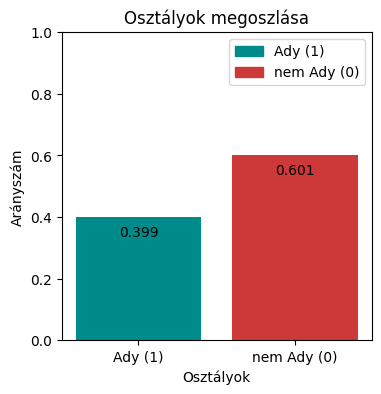

In [22]:
class_label_list = ['Ady (1)', 'nem Ady (0)']
class_label_column = 'class_label'
title_original = 'Osztályok megoszlása'

error_handler(lambda: get_plot_classes_rate(df_without_redundancy, class_label_column, class_label_list, title_original))

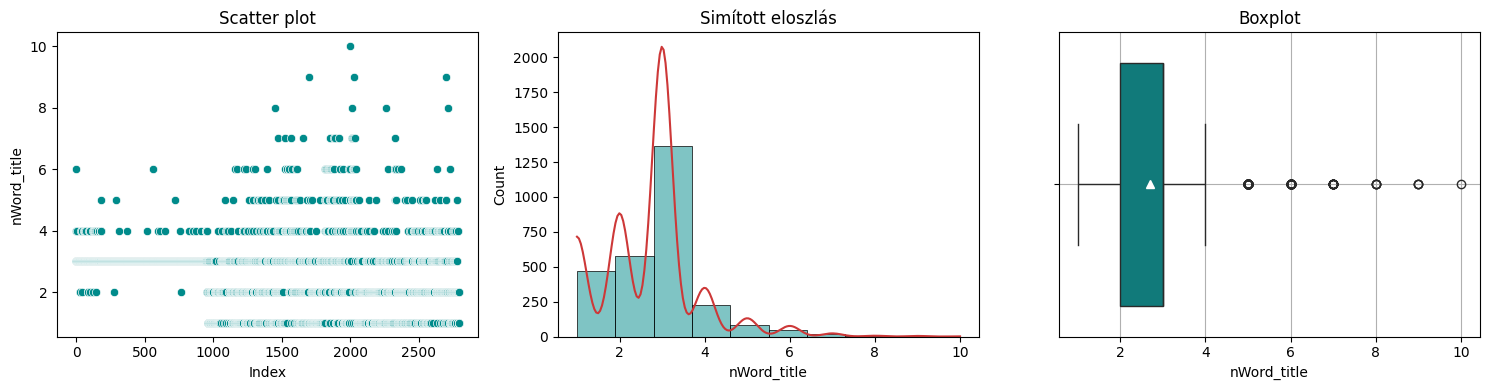

Dropdown(description='Jellemzők:', options=('nWord_title', 'nStanza', 'nLine', 'nWord', 'nSyll', 'rate_shortS'…

In [23]:
feature_options_without_redundancy = ['author', 'title', 'class_label', 'nan_count_label']
initial_feature_without_redundancy = "nWord_title"

error_handler(lambda: distributions(df_without_redundancy, error_handler(lambda: dropdown_features(df_without_redundancy, feature_options_without_redundancy)), initial_feature_without_redundancy))

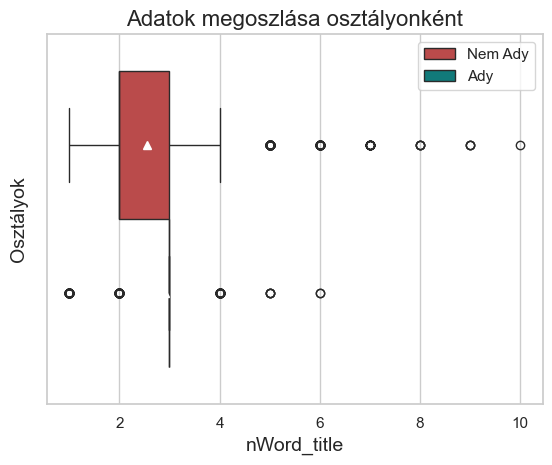

Dropdown(description='Jellemzők:', options=('nWord_title', 'nStanza', 'nLine', 'nWord', 'nSyll', 'rate_shortS'…

In [24]:
error_handler(lambda: distributions_by_class(df_without_redundancy, error_handler(lambda: dropdown_features(df_without_redundancy, feature_options_without_redundancy)), initial_feature_without_redundancy))

                 Relatív szórás
MADmed_nSyll_lg        8.129158
rhyme_aaaa             7.515400
rhyme_abca             7.369020
rhyme_abcdb            6.810180
std_nSyll_lg           6.461775
...                         ...
std_lenWord            0.111072
q3_lenWord             0.105392
rstd_lenWord           0.095894
mean_lenWord           0.084657
rate_consonant         0.019630

[164 rows x 1 columns]


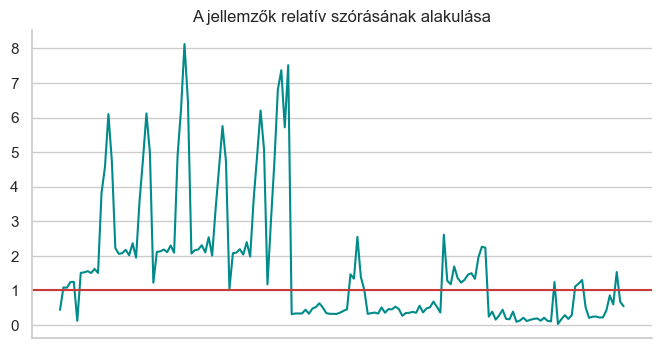

In [25]:
df_rel_stds_without_redundancy = error_handler(lambda: relative_std_datas(df_without_redundancy, True, 2, -2, None))    
error_handler(lambda: relative_std_diagram(df_rel_stds_without_redundancy))

In [26]:
correlation_matrix_pearson_without_redundancy, correlation_matrix_spearman_without_redundancy = error_handler(lambda: correlation_matrix_pearson_spearman(df_without_redundancy, False, False, 2, -1))


In [27]:
# error_handler(lambda: correlation_matrix_heatmap(correlation_matrix_pearson_without_redundancy, 'Korrelációs mátrix (lineáris kapcsolatok)'))


In [28]:
# error_handler(lambda: correlation_matrix_heatmap(correlation_matrix_spearman_without_redundancy, 'Korrelációs mátrix (nem lineáris kapcsolatok)'))

In [29]:
error_handler(lambda: correlation_matrix_treshold(correlation_matrix_pearson_without_redundancy, correlation_matrix_spearman_without_redundancy, False))

FloatSlider(value=0.5, description='Treshold:', max=1.0, step=0.05)

Output()

In [30]:
error_handler(lambda: pairplot_distributions(df_without_redundancy, error_handler(lambda: dropdown_features(df_without_redundancy, feature_options_without_redundancy))))

Dropdown(description='X tengely:', options=('nWord_title', 'nStanza', 'nLine', 'nWord', 'nSyll', 'rate_shortS'…

Dropdown(description='Y tengely:', index=1, options=('nWord_title', 'nStanza', 'nLine', 'nWord', 'nSyll', 'rat…

Output()

### Osztályok kiegyensúlyozása

In [31]:
df_balanced = df_without_redundancy.drop(df_without_redundancy[(df_without_redundancy['class_label'] == 0) & (df_without_redundancy.index % 3 == 0)].index)
# df_balanced.to_csv('poems_data_balanced.csv')
df_balanced.iloc[:, 2:-1].to_csv('data_balanced.csv', index = False)

# df_balanced
# df_balanced.info()

In [32]:
print(df_balanced['author'].value_counts().sort_index())

author
Ady Endre            1116
Babits Mihály         342
Karinthy Frigyes       58
Kosztolányi Dezső     420
Tóth Árpád            301
Name: count, dtype: int64


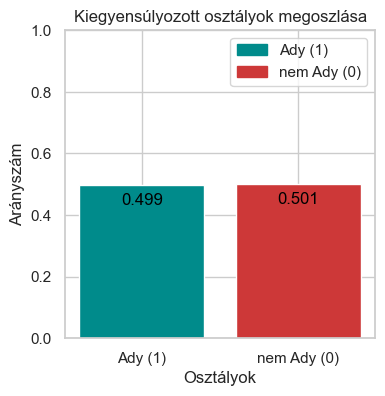

In [33]:
title_balanced = 'Kiegyensúlyozott osztályok megoszlása'
error_handler(lambda: get_plot_classes_rate(df_balanced, class_label_column, class_label_list, title_balanced))

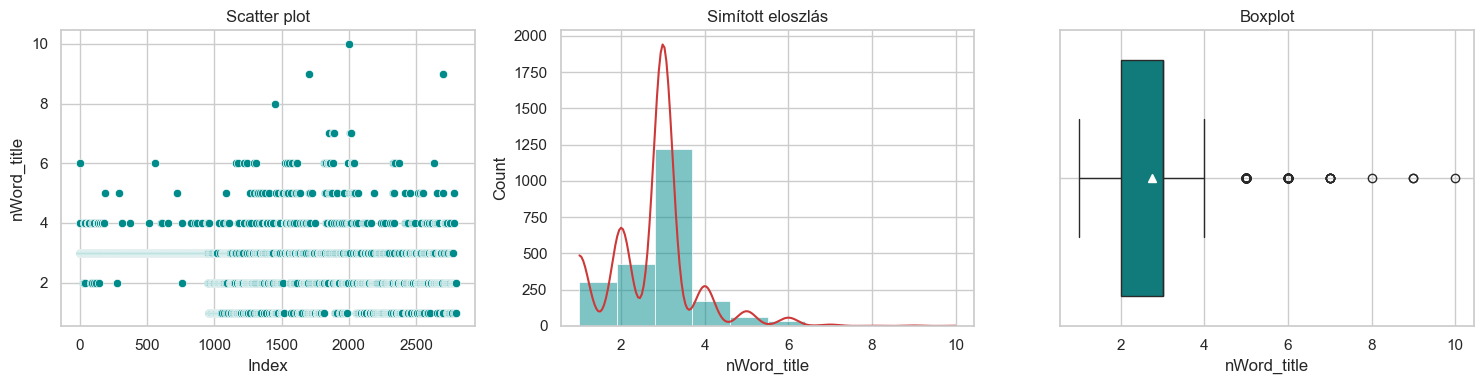

Dropdown(description='Jellemzők:', options=('nWord_title', 'nStanza', 'nLine', 'nWord', 'nSyll', 'rate_shortS'…

In [34]:
feature_options_balanced = ['author', 'title', 'class_label', 'nan_count_label']
initial_feature_balanced = "nWord_title"

error_handler(lambda: distributions(df_balanced, error_handler(lambda: dropdown_features(df_balanced, feature_options_balanced)), initial_feature_balanced))

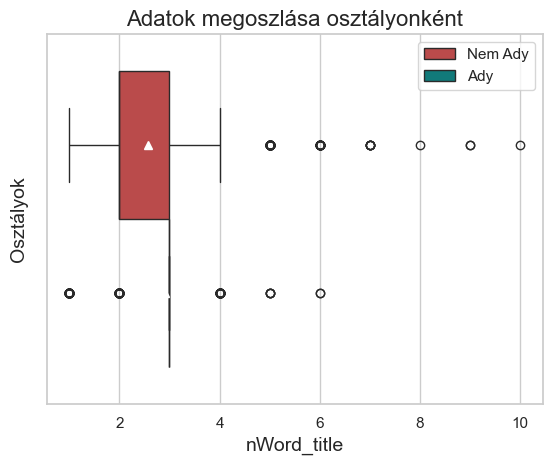

Dropdown(description='Jellemzők:', options=('nWord_title', 'nStanza', 'nLine', 'nWord', 'nSyll', 'rate_shortS'…

In [35]:
error_handler(lambda: distributions_by_class(df_balanced, error_handler(lambda: dropdown_features(df_balanced, feature_options_balanced)), initial_feature_balanced))

### Dimenziószám-csökkentés

Jellemzők kiválasztása szakirodalom alapján (saját jellemzőtér kialakítása)

Kiss Margit: Stilometriai elemzés lehetőségei magyar történeti szövegkorpuszon, 2019, Digitális Bölcsészet
https://www.academia.edu/41112541/Stilometriai_elemz%C3%A9s_lehet%C5%91s%C3%A9gei_magyar_t%C3%B6rt%C3%A9neti_sz%C3%B6vegkorpuszon

In [36]:
X = df_without_redundancy.iloc[:, :-2]
y = df_without_redundancy['class_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# get_plot_classes_rate(pd.DataFrame(y_train), class_label_column, class_label_list, title_original)

Xy_train = pd.concat([X_train, pd.DataFrame(y_train)], axis = 1)
# Xy_train

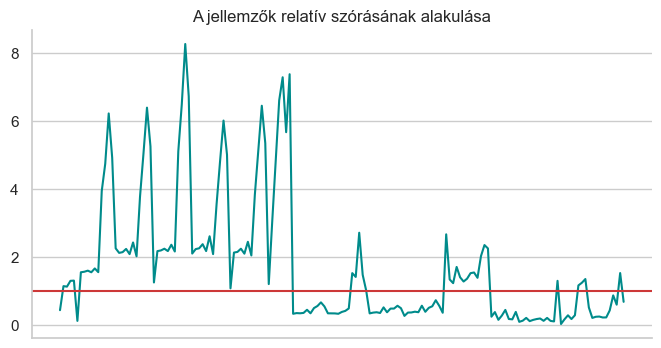

In [37]:
df_rel_stds_Xy_train = error_handler(lambda: relative_std_datas(Xy_train, False, 2, -2, None))
error_handler(lambda: relative_std_diagram(df_rel_stds_Xy_train))

In [38]:
correlation_matrix_pearson_Xy_train, correlation_matrix_spearman_Xy_train = error_handler(lambda: correlation_matrix_pearson_spearman(Xy_train, False, False, 2, -1))

In [39]:
error_handler(lambda: correlation_matrix_treshold(correlation_matrix_pearson_Xy_train, correlation_matrix_spearman_Xy_train, False))

FloatSlider(value=0.5, description='Treshold:', max=1.0, step=0.05)

Output()

In [40]:
# nWord = Xy_train.loc[:, ['nWord_title', 'nWord']]
# nWord_lg = Xy_train.loc[:, 'mean_nWord_lg':'rstd_nWord_lg']
# nSyll_lg = Xy_train.loc[:, 'mean_nSyll_lg':'rstd_nSyll_lg']
# rhyme = Xy_train.loc[:, 'rhyme_abcb':'rhyme_aaaa']
# nWord_l = Xy_train.loc[:, 'mean_nWord_l':'rstd_nWord_l']
# nSyll_l = Xy_train.loc[:, 'mean_nSyll_l':'rstd_nSyll_l']
# function_words = Xy_train.loc[:, ['PRON', 'ADV', 'CONJ', 'SCONJ', 'DET', 'ADP']]
# lenWord = Xy_train.loc[:, 'mean_lenWord':'rstd_lenWord']
# punct = Xy_train.loc[:, 'PUNCT']
# alliteration = Xy_train.loc[:, 'nAll':'rstd_lenAll']

In [41]:
# top_features = [
                # 'nWord_title', 'nWord', 'q3_nWord_lg', 'max_nWord_lg', 'q3_nSyll_lg', 'max_nSyll_lg', 'MADmed_nSyll_lg', 'rstd_nSyll_lg', 'rhyme_abcdb', 'rhyme_abca', 'rhyme_aaaa'
                # 'q1_nWord_l', 'q3_nWord_l', 'max_nWord_l', 'max_nSyll_l', 'q3_nSyll_l', 'MADmed_nSyll_l', 'PRON', 'ADV', 'CONJ', 'SCONJ', 'DET', 'ADP',
                # 'mean_lenWord', 'med_lenWord', 'PUNCT', 'nAll', 'range_lenAll'
                # ]
top_features_best_with_class_label = [
                    'nWord_title', 'nStanza', 'q3_nSyll_lg', 'MADmed_nSyll_lg', 'rstd_nSyll_lg', 'rhyme_abcdb', 'rhyme_abca', 'rhyme_aaaa',
                    'q1_nWord_l', 'MADmed_nSyll_l', 'SCONJ', 'DET', 'ADP', 'med_lenWord', 'PUNCT', 'range_lenAll', 'class_label'
                    ]
df_top_features_train = Xy_train.loc[:, top_features_best_with_class_label]
df_top_features = df_without_redundancy.loc[:, top_features_best_with_class_label]
df_top_features.to_csv('data_top_features.csv', index = False)
print(len(top_features_best_with_class_label) - 1, "jellemző")
# print(df_top_features)

16 jellemző


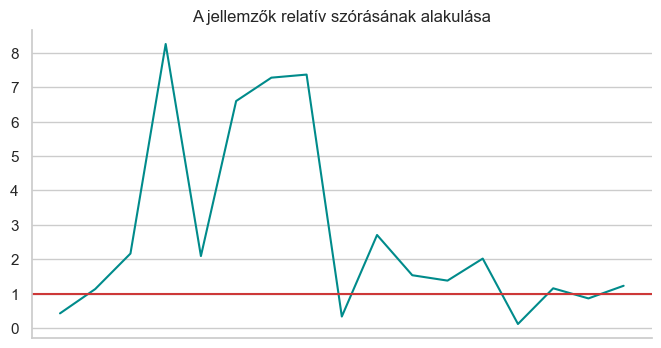

In [42]:
df_rel_stds = error_handler(lambda: relative_std_datas(df_top_features_train, False, None, None, -1))
error_handler(lambda: relative_std_diagram(df_rel_stds))

In [43]:
correlation_matrix_pearson, correlation_matrix_spearman = error_handler(lambda: correlation_matrix_pearson_spearman(df_top_features_train, False, False, None, None))

In [44]:
error_handler(lambda: correlation_matrix_treshold(correlation_matrix_pearson, correlation_matrix_spearman, True))

FloatSlider(value=0.5, description='Treshold:', max=1.0, step=0.05)

Output()

In [45]:
X_train_num = X_train.iloc[:, 2:]
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X_train_num) 

pca = PCA(n_components = 3) 
X_pca = pca.fit_transform(X_scaled)

print("Eredeti alak: %s" % str(X_scaled.shape)) 
print("Redukált alak: %s" % str(X_pca.shape)) 

Eredeti alak: (2238, 164)
Redukált alak: (2238, 3)


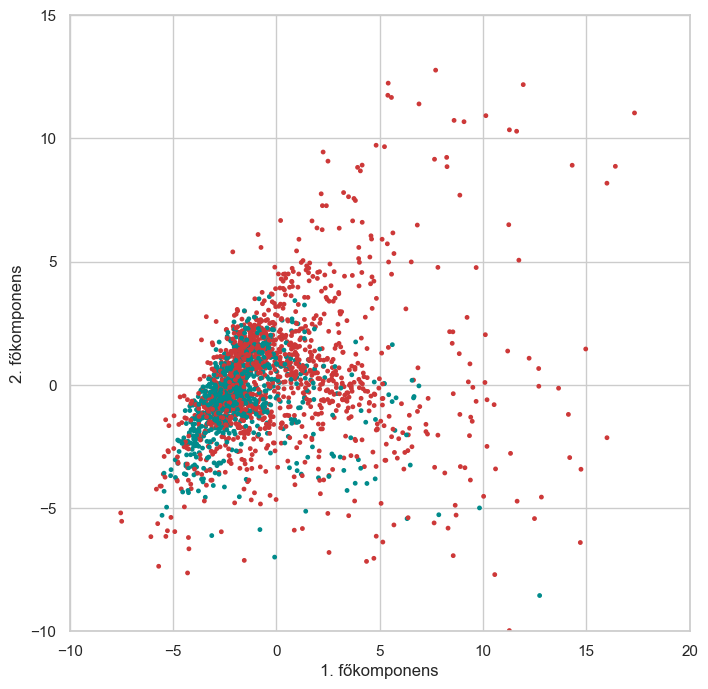

In [46]:
cmap = ListedColormap(['#cd3838', 'darkcyan'])
error_handler(lambda: pca_2D(X_pca, 0, -10, 20, 1, -10, 15, y_train, cmap))

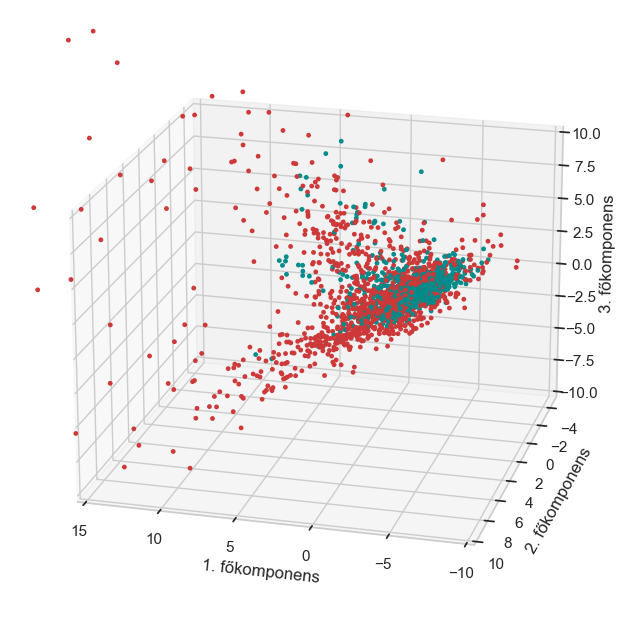

In [47]:
error_handler(lambda: pca_3D(X_pca, 0, -10, 15, 1, -5, 10, 2, -10, 10, y_train, cmap, 20, 105))